# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



## Подготовка и импорт библиотек

In [1]:
import os
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image

C:\Users\vitg1\AppData\Local\Temp\ipykernel_17416\18574234.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
import random 
SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
TRAIN_DIR = Path('C:/Users/vitg1/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('C:/Users/vitg1/journey-springfield/testset/testset')

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
CUDA_LAUNCH_BLOCKING=1
BATCH_SIZE=128

In [4]:
print(DEVICE)

cuda:0


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

## Загрузка данных

In [6]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [7]:
n_classes = len(np.unique(train_val_labels))
train_labels = [path.parent.name for path in train_files] 
val_labels = [path.parent.name for path in val_files]

In [8]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [9]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [10]:
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [11]:
def create_dct_from_labels(train_val_labels):

    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]## Загрузка данных

In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [13]:
def fit_epoch(model, train_dataloader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE) 
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0) 
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0) 
              
    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data 
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_dataloader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
       
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_dataloader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
model = models.alexnet(pretrained=True)

C:\Users\vitg1\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vitg1\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
layers_to_unfreeze = 5

for param in model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
model.classifier = nn.Linear(9216, n_classes)

model = model.to(DEVICE)

In [18]:
history = train(new_train_dataset, val_dataset, model=model, epochs=10, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.3789301906686169


epoch:  10%|█         | 1/10 [03:21<30:10, 201.12s/it]


Epoch 001 train_loss: 1.3789     val_loss 0.6227 train_acc 0.6514 val_acc 0.8355
loss 0.3802454226307701


epoch:  20%|██        | 2/10 [06:49<27:24, 205.58s/it]


Epoch 002 train_loss: 0.3802     val_loss 0.4360 train_acc 0.8978 val_acc 0.8888
loss 0.2127065447483517


epoch:  30%|███       | 3/10 [10:06<23:32, 201.74s/it]


Epoch 003 train_loss: 0.2127     val_loss 0.4025 train_acc 0.9452 val_acc 0.9047
loss 0.13276079239913013


epoch:  40%|████      | 4/10 [13:14<19:36, 196.05s/it]


Epoch 004 train_loss: 0.1328     val_loss 0.4110 train_acc 0.9663 val_acc 0.9043
loss 0.08460851213606761


epoch:  50%|█████     | 5/10 [16:15<15:53, 190.61s/it]


Epoch 005 train_loss: 0.0846     val_loss 0.4402 train_acc 0.9792 val_acc 0.9073
loss 0.06353265717603568


epoch:  60%|██████    | 6/10 [19:17<12:30, 187.74s/it]


Epoch 006 train_loss: 0.0635     val_loss 0.4644 train_acc 0.9840 val_acc 0.9056
loss 0.04903246702311589


epoch:  70%|███████   | 7/10 [22:21<09:19, 186.40s/it]


Epoch 007 train_loss: 0.0490     val_loss 0.4972 train_acc 0.9882 val_acc 0.9098
loss 0.03297072857680071


epoch:  80%|████████  | 8/10 [25:23<06:10, 185.26s/it]


Epoch 008 train_loss: 0.0330     val_loss 0.4882 train_acc 0.9912 val_acc 0.9125
loss 0.02712276000761049


epoch:  90%|█████████ | 9/10 [28:33<03:06, 186.68s/it]


Epoch 009 train_loss: 0.0271     val_loss 0.4807 train_acc 0.9933 val_acc 0.9083
loss 0.02228851986552315


epoch: 100%|██████████| 10/10 [31:43<00:00, 190.34s/it]


Epoch 010 train_loss: 0.0223     val_loss 0.5055 train_acc 0.9955 val_acc 0.9135


In [19]:
torch.save(model.state_dict(), 'AlexNet.pth')
model.load_state_dict(torch.load('AlexNet.pth'))

<All keys matched successfully>

In [20]:
loss, acc, val_loss, val_acc = zip(*history)

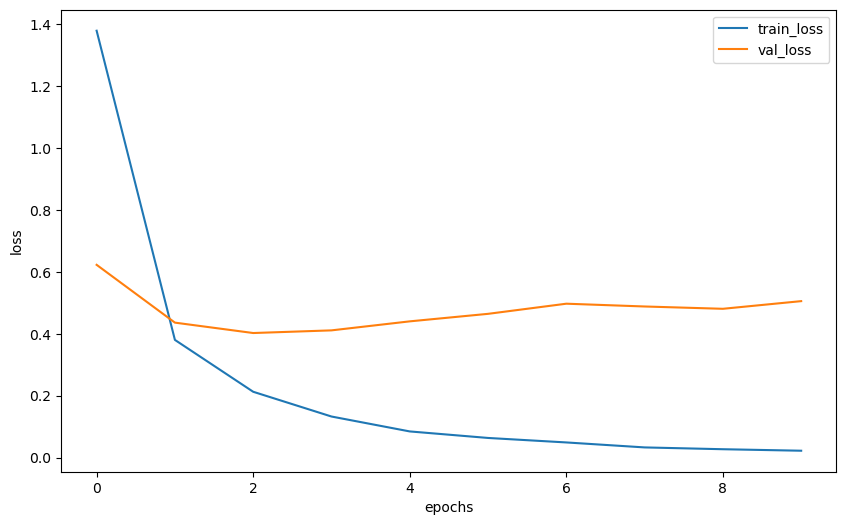

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

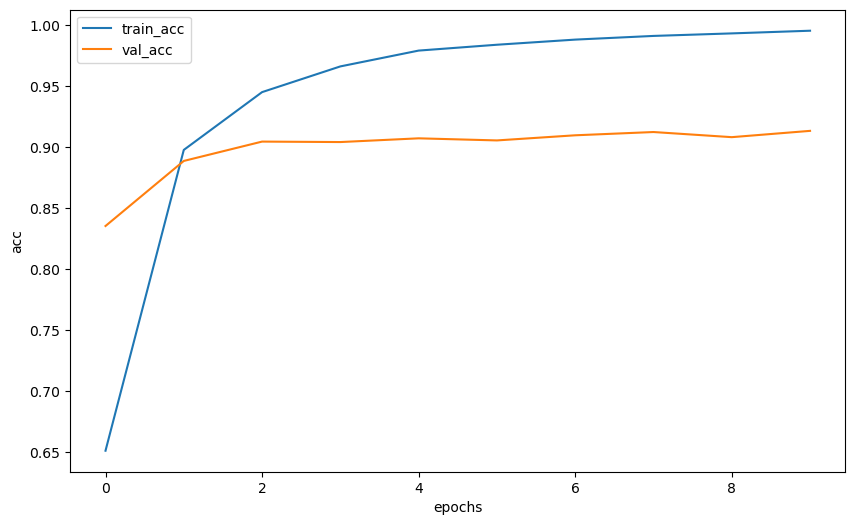

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label="train_acc")
plt.plot(tuple(i.tolist() for i in val_acc), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

## Предсказания и submit

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [25]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [27]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('submission.csv', index = False)